In [1]:
%pip install matplotlib
%pip install numpy==1.23.5
%pip install opencv-python
%pip install medpy==0.4.0
%pip install tqdm
%matplotlib inline
%pip install pandas

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.

Note: you may need to restart the kernel to use updated packages.


In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap
import sys
import os
plt.rcParams["figure.figsize"] = (15,15)

print(f"numpy version : {np.__version__}")

%load_ext autoreload
%autoreload 2

numpy version : 1.23.5


In [3]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [4]:
# from keras_unet.losses import dice_loss
# from keras_unet.metrics import dice_coef, iou, iou_thresholded
from keras_unet.visualization import plot_overlay_segmentation
from keras_unet.visualization import plot_compare_segmentation
from keras_unet.visualization import visualize_BestWorstOnes

# Add our own python modules stored in the folders present at the root level of this project
if "../" in sys.path: 
    print(sys.path)
else: 
    sys.path.append("../")
    print(sys.path)

if "model" in locals(): 
    print("deleting model")
    del model    
    
# Select the CPU device to run on
num_CPU = 1
num_cores = 8
tf.config.threading.set_intra_op_parallelism_threads(num_CPU)
tf.config.threading.set_inter_op_parallelism_threads(num_cores)
os.environ["TF_CPP_MIN_LOG_LEVEL"]="3" 

['c:\\Users\\user\\Desktop\\zhuyi\\PTI\\camus-hands-on-main', 'c:\\Users\\user\\anaconda3\\envs\\py310\\python310.zip', 'c:\\Users\\user\\anaconda3\\envs\\py310\\DLLs', 'c:\\Users\\user\\anaconda3\\envs\\py310\\lib', 'c:\\Users\\user\\anaconda3\\envs\\py310', '', 'c:\\Users\\user\\anaconda3\\envs\\py310\\lib\\site-packages', 'c:\\Users\\user\\anaconda3\\envs\\py310\\lib\\site-packages\\win32', 'c:\\Users\\user\\anaconda3\\envs\\py310\\lib\\site-packages\\win32\\lib', 'c:\\Users\\user\\anaconda3\\envs\\py310\\lib\\site-packages\\Pythonwin', '../']


## <span style="color:brown"> 1.1) Load data

In [5]:
from keras_unet.utils import load_SUMAC_dataset
dataset_dir = "./dataset/sumac_256/"
X, y = load_SUMAC_dataset(dataset_dir, img_size=256, 
                          extension="nii.gz",random_state=42)

100%|██████████| 1000/1000 [00:03<00:00, 278.97it/s]


randomly picked indices : [171]


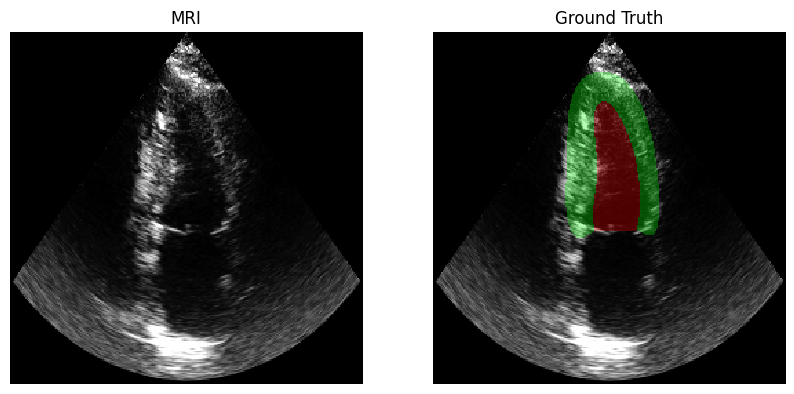

In [6]:
from keras_unet.visualization import plot_superposition
from tqdm import tqdm

nb = 1
ixs = np.random.choice(len(X), nb) 
print(f'randomly picked indices : {ixs}')
plot_overlay_segmentation(X[ixs, ], y[ixs,])

## Load a trained model

In [7]:
from tensorflow.keras import models
from keras_unet.losses import dice_loss
from keras_unet.metrics import dice_coef

model_path = './trained_model/trained_Unet_f32_b16_l4_do0.1_Std_BN_input_epoch_176.h5'
model = models.load_model(model_path, 
              custom_objects={'dice_coef': dice_coef, 'dice_loss': dice_loss})    

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 32  320         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                             

# Prediction

In [17]:
from keras_unet.evaluation import  evaluate_segmentation, evaluate_set_each3, evaluate_set_avr
import pandas as pd
from IPython.display import display, HTML 

limit = 1000
X_picked = X[:limit,]
y_picked = y[:limit]

# Predict segmentations on the full test dataset
y_pred = model.predict(X_picked, batch_size=1, verbose=1)

# # make the prediction labels correspond to those of the new GT 
y_pred[:,:,:,1] = y_pred[:,:,:,3]
y_pred = np.delete(y_pred,-1,axis=-1)

y_pred.shape

1000/1000 [==============================] - 10s 10ms/step


(1000, 256, 256, 3)

### Check label coherence between GT and Pred

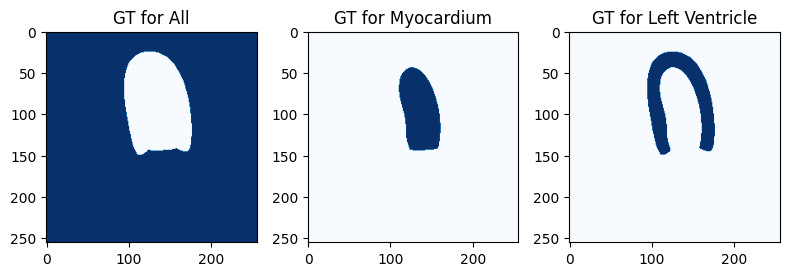

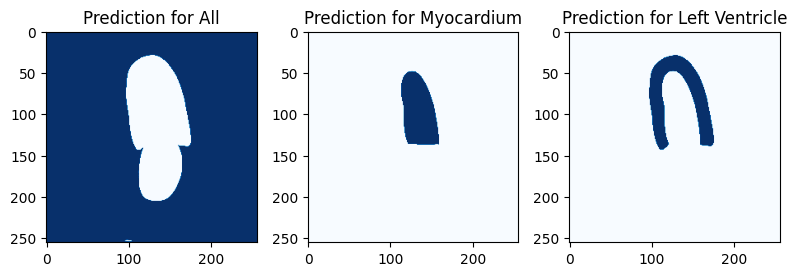

In [18]:
# show labels of a GT
ix_picked = 1

size = 8

y1 = y[ix_picked,]
fig, ax = plt.subplots(1,3,figsize=(size,size))
ax = ax.ravel()
for i, label_name in enumerate(["All", "Myocardium", "Left Ventricle"]):
    ax[i].imshow(y1[:,:,i],cmap='Blues')
    ax[i].set_title(f'GT for {label_name}')

fig.tight_layout()

# show labels of a prediction 
y1 = y_pred[ix_picked,]
fig, ax = plt.subplots(1,3,figsize=(size,size))
ax = ax.ravel()
for i, label_name in enumerate(["All", "Myocardium", "Left Ventricle"]):
    ax[i].imshow(y1[:,:,i],cmap='Blues')
    ax[i].set_title(f'Prediction for {label_name}')

fig.tight_layout()



<font color='red'> **GT label_0 different from Prediction label_0 ? No worries ! See line 23 of `evaluation.py`**

# Evaluation

In [20]:
df = evaluate_set_each3(y_picked, y_pred, voxel_spacing = [1.0, 1.0])
df.head() 

100%|██████████| 1000/1000 [00:26<00:00, 38.15it/s]


Dice                            Hausdorff             \
                  All Myocardium Left Ventricle        All Myocardium   
image index                                                             
0            0.388243   0.324115       0.432146  65.391131  63.031738   
1             0.69895    0.86175       0.593979       61.0       61.0   
2            0.771033   0.823474       0.706088  58.180753       56.0   
3            0.772964   0.801073       0.748543  31.780497  31.780497   
4            0.673898    0.75779       0.609539  60.166436  60.166436   

                                 ASSD                            
            Left Ventricle        All Myocardium Left Ventricle  
image index                                                      
0                65.391131  15.411167  18.120649      12.701685  
1                60.373835   8.130052   8.596086       7.664018  
2                58.180753   9.340723  10.217643       8.463803  
3                15.556349   4.979213   5.969781       3.988645  
4                54.230987   10.24704  12.592312       7.901767

C:\Users\user\AppData\Local\Temp\ipykernel_23116\2435470245.py:11: FutureWarning: The behavior of Series.argsort in the presence of NA values is deprecated. In a future version, NA values will be ordered last instead of set to -1.
  ixs_ascend_sort = df.loc[:,(metric, label)].argsort().values


[ 66 808 276]


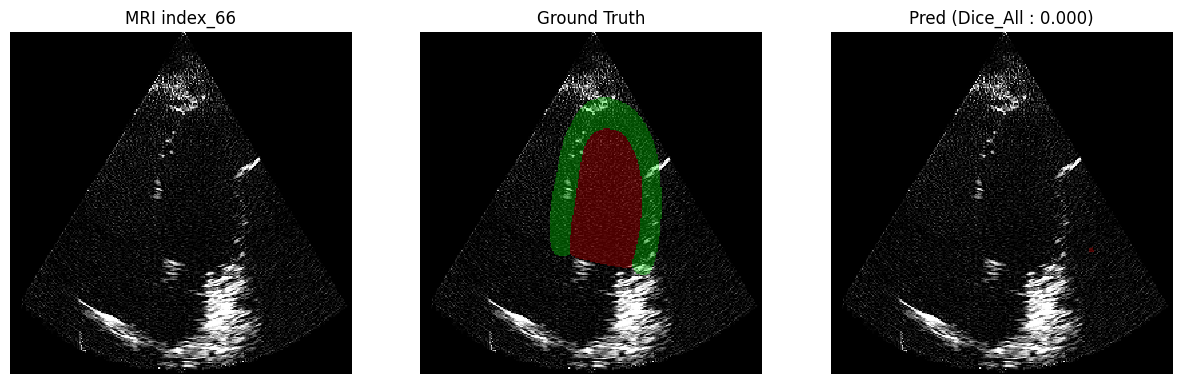

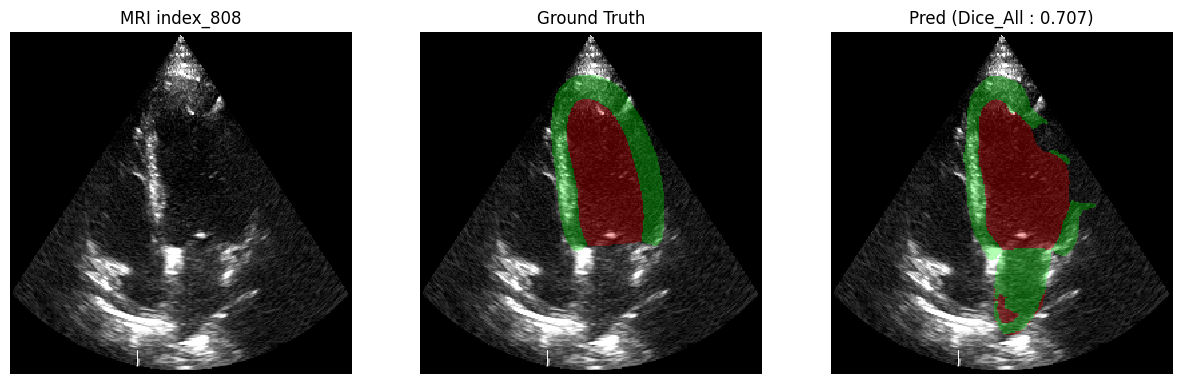

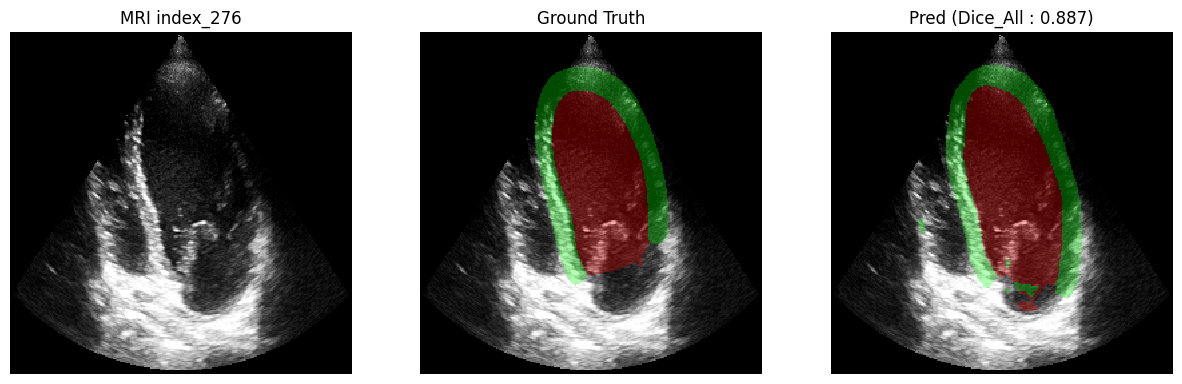

In [21]:
metric = 'Dice'  # The evaluation metric to be used
label = 'All'  # The label for which the metric is calculated
nb_show = 1  # Number of images to show
show_best = True  # Flag to show the images with the best metric scores
show_worst = True  # Flag to show the images with the worst metric scores
show_middle = True  # Flag to show the images with the median metric scores

ixs_show = []  # Initialize an empty list to store indices of images to show

# Get the ascending order indices of the DataFrame based on the metric scores for the specified label
ixs_ascend_sort = df.loc[:,(metric, label)].argsort().values

# If set to show the worst, get the first `nb_show` indices (worst scores)
if show_worst:
    ixs_worst = ixs_ascend_sort[:nb_show]
    ixs_show.append(ixs_worst)
    
# If set to show the middle, calculate the middle index and get `nb_show` indices around the median
if show_middle:
    middle_index = len(ixs_ascend_sort) // 2 
    ixs_moyen = ixs_ascend_sort[middle_index - nb_show // 2:middle_index + (nb_show + 1) // 2]
    ixs_show.append(ixs_moyen)
    
# If set to show the best, get the last `nb_show` indices (best scores)
if show_best:
    ixs_best = ixs_ascend_sort[-nb_show:]
    ixs_show.append(ixs_best)

# Combine all the indices into a single array
ixs_show = np.concatenate(ixs_show)

print(ixs_show)  # Print the indices of the images to be shown


# Prepare titles for the images based on their indices
metric_values = df.loc[:,(metric, label)][ixs_show].values

titles_for_imgs = []  # List to hold titles for the images
for ix in ixs_show:
    titles_for_imgs.append(f'MRI index_{ix}')  # Title for each image

titles_for_preds = []  # List to hold titles for the predictions
for value in metric_values:
    titles_for_preds.append(f"Pred ({metric}_{label} : {value:.3f})")  # Title for each prediction with the metric score

# Call the function to plot and compare segmentation for the selected images and predictions
plot_compare_segmentation(X_picked[ixs_show, ], y_picked[ixs_show,], y_pred[ixs_show,], 
                          " ", spacing=(1,1), step=1, img_titles=titles_for_imgs,
                          pred_titles=titles_for_preds)

100%|██████████| 1000/1000 [00:29<00:00, 33.57it/s]


,Dice,Hausdorff (px),ASSD (px)
All,0.66,65.21,10.23
Myocardium,0.72,60.09,11.54
Left Ventricle,0.62,60.14,8.76


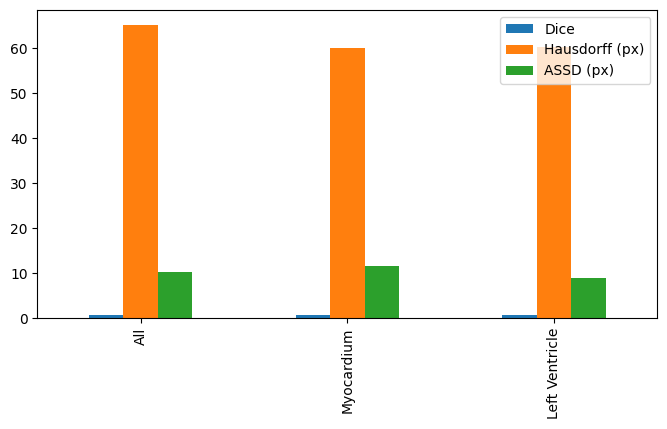

In [22]:
# Compute score on the full test dataset
dice_all, hausdorff_all, assd_all, valid_all = \
                       evaluate_set_avr(y[:limit, ], y_pred[:limit, ])

# Put the results into a matrix and graft it into a pandas data frame 
overall_results = np.column_stack((dice_all, hausdorff_all, assd_all))
overall_results_df = pd.DataFrame(data=overall_results, 
                                  index = ["All", "Myocardium", "Left Ventricle"], 
                                  columns=["Dice", "Hausdorff (px)", "ASSD (px)"]) 

# overall_results_df = pd.DataFrame(data=overall_results, 
#                                   index = ["All", "Right Ventricle", "Myocardium", "Left Ventricle"], 
#                                   columns=["Dice", "Hausdorff (px)", "ASSD (px)"]) 

# Display the data as HTML tables and graphs
display(HTML(overall_results_df.to_html(float_format=lambda x: '%.2f' % x)))
overall_results_df.plot(kind='bar', figsize=(8,4)).legend() #bbox_to_anchor=(1.6,0.9))

,Max Score,Median Score,Min Score
All,0.89,0.71,0.00
Myocardium,0.94,0.79,0.00
Left Ventricle,0.85,0.64,0.00


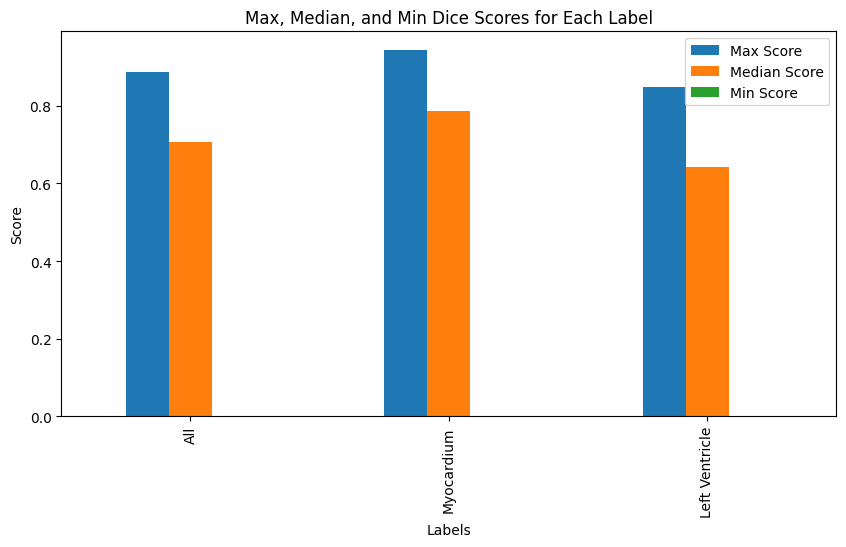

,Max Score,Median Score,Min Score
All,183.00,65.19,12.00
Myocardium,182.99,62.00,6.08
Left Ventricle,183.00,60.64,12.00


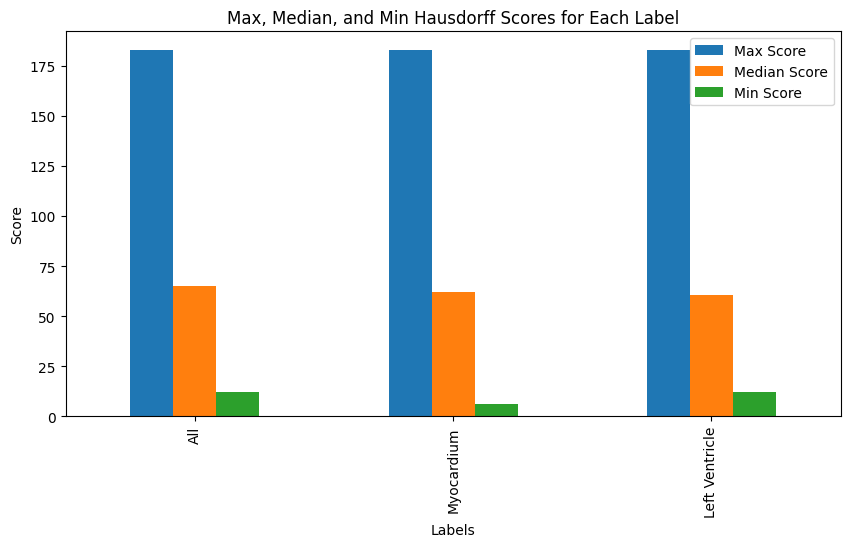

,Max Score,Median Score,Min Score
All,97.66,9.27,2.36
Myocardium,113.52,10.63,1.80
Left Ventricle,97.66,7.95,2.51


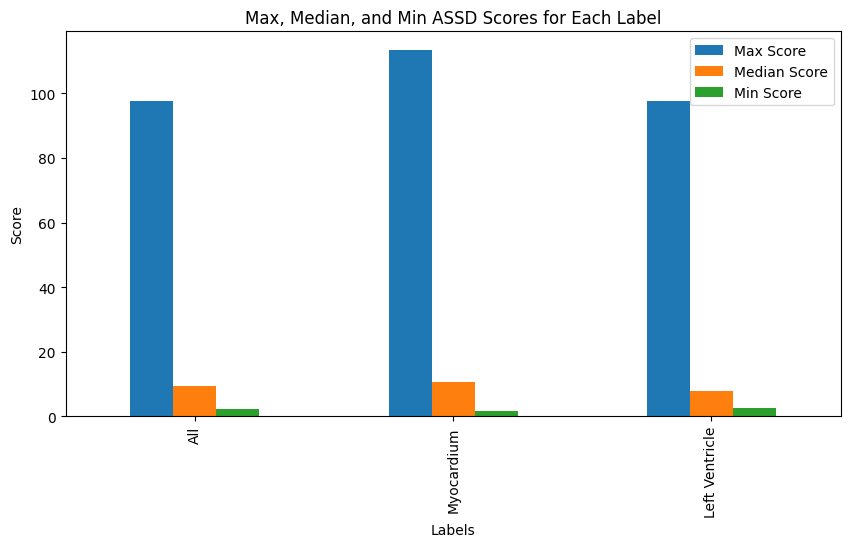

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import HTML

# Define the metrics to plot
metrics = ['Dice', 'Hausdorff', 'ASSD']

# Loop through each metric and create separate tables and plots
for metric in metrics:
    # Filter the DataFrame for the current metric
    df_metric = df.xs(metric, level=0, axis=1)

    # Calculate the best, worst, and median scores for the current metric
    best_scores = df_metric.max()
    median_scores = df_metric.median()
    worst_scores = df_metric.min()

    # Create a DataFrame to display these results
    results_data = {
        "Max Score": best_scores,
        "Median Score": median_scores,
        "Min Score": worst_scores
    }
    results_df = pd.DataFrame(results_data)

    # Display the DataFrame
    display(HTML(f"<h3>{metric} Scores</h3>"))
    display(HTML(results_df.to_html(float_format=lambda x: '%.2f' % x)))

    # Plotting the results
    results_df.plot(kind='bar',figsize=(10, 5))
    plt.title(f'Max, Median, and Min {metric} Scores for Each Label')
    plt.ylabel('Score')
    plt.xlabel('Labels')
    plt.show()


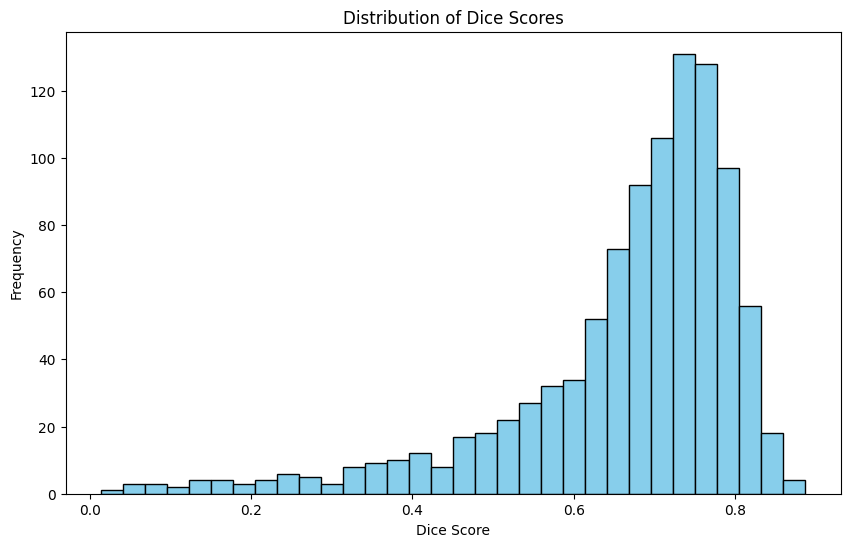

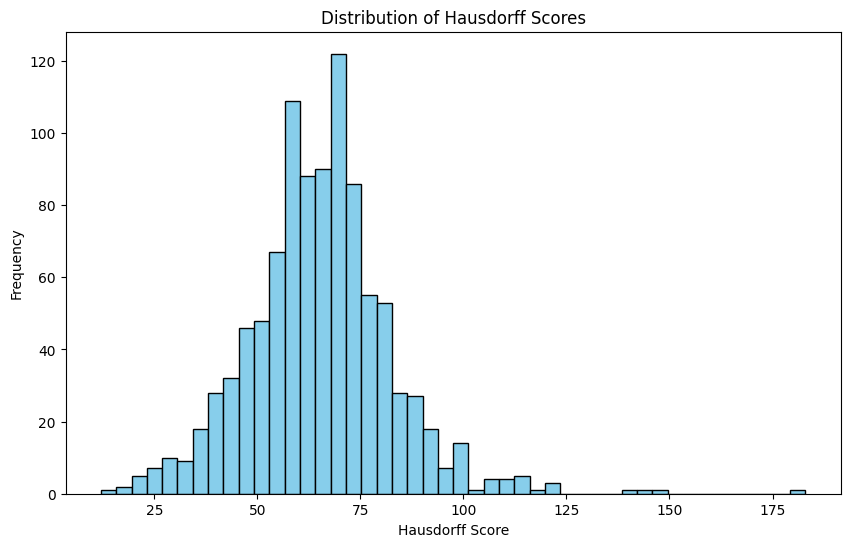

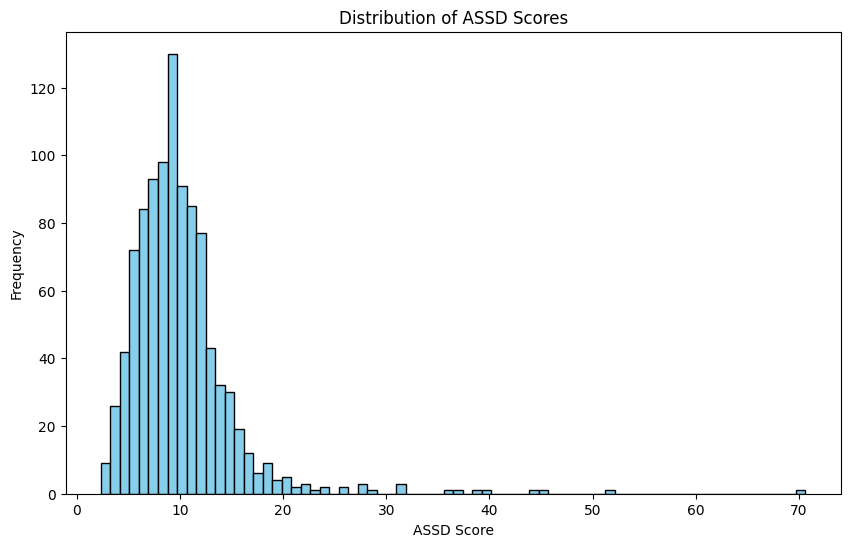

In [24]:
import pandas as pd
import matplotlib.pyplot as plt

# Function to drop rows with invalid values
def drop_invalid_rows(df):
    return df.dropna()

# Assuming df is your DataFrame with the scores
df_clean = drop_invalid_rows(df)

# Metrics to plot
metrics = ['Dice', 'Hausdorff', 'ASSD']
label = 'All'  # Assuming you want to plot for the 'all' label

# Plot the distribution of each metric
for metric in metrics:
    plt.figure(figsize=(10, 6))
    plt.hist(df_clean.loc[:, (metric, label)], bins='auto', color='skyblue', edgecolor='black')
    plt.title(f'Distribution of {metric} Scores')
    plt.xlabel(f'{metric} Score')
    plt.ylabel('Frequency')
    plt.show()


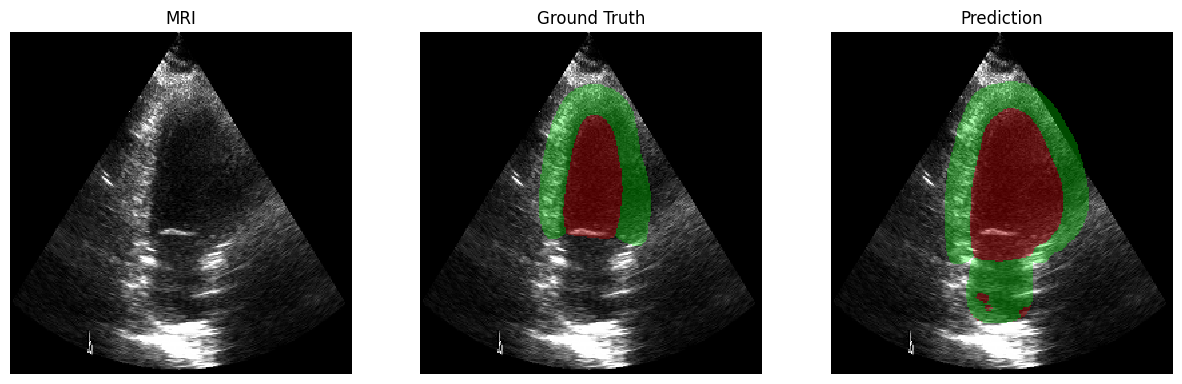

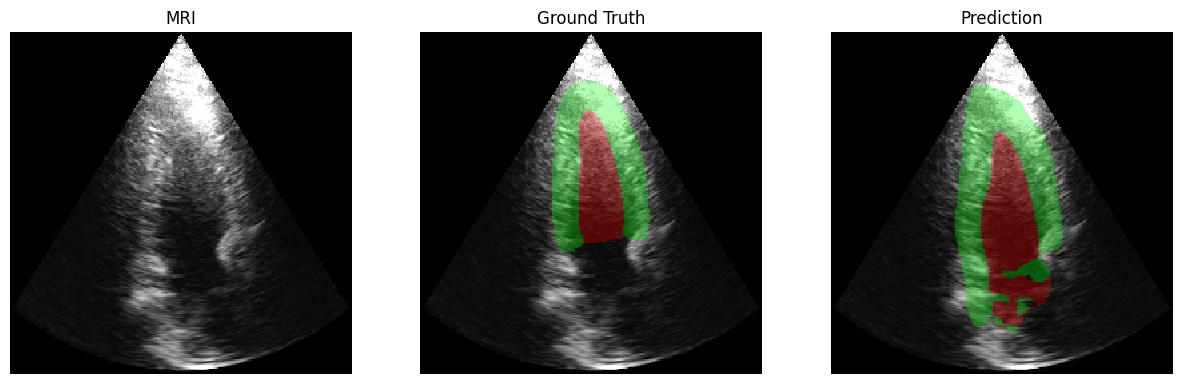

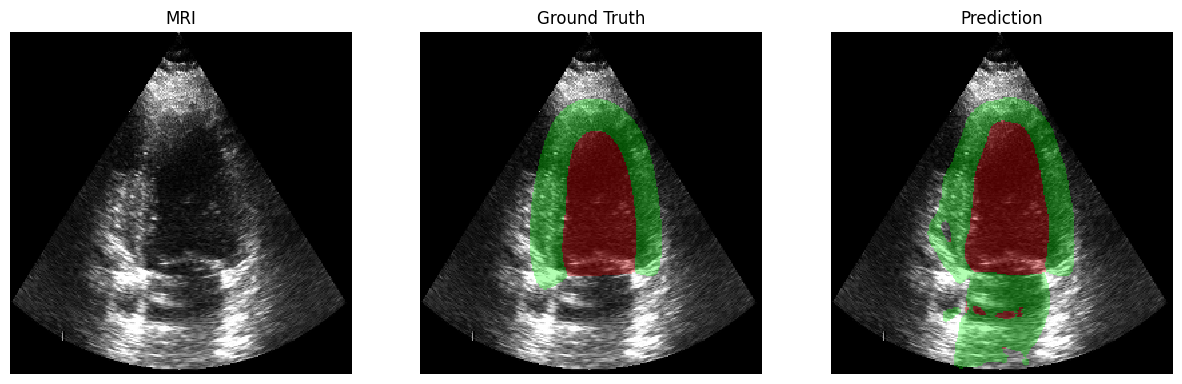

In [25]:
# Select random values
nb_imgs = 3
start_ind = (np.random.randint(0, X.shape[0]-nb_imgs, size=1))[0]
end_ind = start_ind+nb_imgs

# Display the random images with the corresponding reference and predicted mask
plot_compare_segmentation(X[start_ind:end_ind], y[start_ind:end_ind], y_pred[start_ind:end_ind], " ", spacing=(1,1), step=1)

En attendant, je vous conseille d'avancer sur votre code, notamment pour la présentation des résutlats dans un jupyterlab.  

Je pense qu'il serait bien que codiez une fonction qui récupère les N images ayant les scores les plus faibles, les N images ayant les scores les plus élevés et que vous les affichier.  

Ca permettra d'avoir l'ensemble des outils lorsque vous allez traiter la 2ème base de données.

dice_all.shape